# Density estimation with Normalizing Flow CATHODE style

## Toy example set up

Define the following event variables $\alpha$ and $\beta$, which can be ued to define SR.

$$
p(\alpha) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\alpha^{2}}{2}}
$$

$$
p(\beta) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{\beta^{2}}{2}}
$$

This example discuesses the inference/extrapolation of the probability dentisity distribution of variable $y$, which has dependence on the event variables, conditioned in 1 and 2 dimentions. 

**Inference variable**

$$
P(y) = N( \mu = k ( \cos{\theta} \alpha + \sin{\theta} \beta) ,\sigma^2 = 1)
$$

**1D inference**

In the 1D case, we can set $\theta=0$. 

$$
P(y) = N(k\alpha,1)
$$

**Equalized 2D inference**

To have the same dependce on $\alpha$ and $\beta$, we can set $\theta=\frac{\pi}{4}$. 

$$
P(y) = N( k(\alpha +\beta), 1)
$$

**Working points**

In this example, we test the inference with the following working points:


|     1D inference    |   Equalized 2D inference   |     General 2D inference   |
| --- | --- | --- | 



| $k$      | $\theta$ |    $k$      |    $\theta$   |    $k$      |    $\theta$   |
| -------- | -------- | ----------- | ------------- | ----------- | ------------- |
| 0.0      | 0        |    0.0      |    $\pi/4$    |    0.5      |    $ \pi/8$   | 
| 0.2      | 0        |    0.2      |    $\pi/4$    |    0.5      |    $3\pi/8$   |
| 0.5      | 0        |    0.5      |    $\pi/4$    |    1.0      |    $ \pi/8$   |
| 1.0      | 0        |    1.0      |    $\pi/4$    |    1.0      |    $3\pi/8$   |
| 1.5      | 0        |    1.5      |    $\pi/4$    |    1.5      |    $ \pi/8$   |
| 2.0      | 0        |    2.0      |    $\pi/4$    |    1.5      |    $3\pi/8$   |

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, pi
import torch
import os

In [14]:
# Total number of events
N1 = 100000
# Total number of signal
N2 = 1000

In [15]:
def Y(k, theta, x1, x2, n=N1, sigma=1):
    return np.random.normal(k*(cos(theta)*x1 + sin(theta)*x2), sigma, n).astype(dtype=np.float32)

### Define the training model

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

cuda available: True


In [5]:
from helpers.SimpleMAF import *
from helpers.plotting import *

In [8]:
x1 = np.random.normal(0, 1, N1).astype(dtype=np.float32)
mask_CR1D = x1 < 1
mask_SR1D = x1 > 1

x2 = np.random.normal(0, 1, N1).astype(dtype=np.float32)
data = np.stack([x1, x2], axis = -1)
mask_CR = np.logical_not((data[:,0] > 1) & (data[:,1] > 1))
mask_SR = (data[:,0] > 1) & (data[:,1] > 1)

x3 = np.random.normal(3, 0.5, N2).astype(dtype=np.float32)
x4 = np.random.normal(3, 0.5, N2).astype(dtype=np.float32)

In [37]:
def MAF1D(Y_list, cond):
    samples_CR_list = []
    samples_SR_list = []
    for i in range(len(Y_list)):
        MAF = SimpleMAF(num_features = 1, num_cond_features=1, device=device)
        MAF.train(data=Y_list[i][mask_CR1D], cond=cond[mask_CR1D])
        samples_CR_list.append(MAF.sample(1, cond[mask_CR1D].reshape(-1,1)).reshape((cond[mask_CR1D].shape)))
        samples_SR_list.append(MAF.sample(1, cond[mask_SR1D].reshape(-1,1)).reshape((cond[mask_SR1D].shape)))
        del MAF
    return samples_CR_list, samples_SR_list

In [38]:
def MAF2D(Y_list, cond):
    samples_CR_list = []
    samples_SR_list = []
    for i in range(len(Y_list)):
        MAF = SimpleMAF(num_features = 1, num_cond_features=2, device=device)
        MAF.train(data=Y_list[i][mask_CR], cond=cond[mask_CR])
        samples_CR_list.append(MAF.sample(1, cond[mask_CR]).reshape(Y_list[i][mask_CR].shape))
        samples_SR_list.append(MAF.sample(1, cond[mask_SR]).reshape(Y_list[i][mask_SR].shape))
        del MAF
    return samples_CR_list, samples_SR_list

## Inference in 1D

<function matplotlib.pyplot.close(fig=None)>

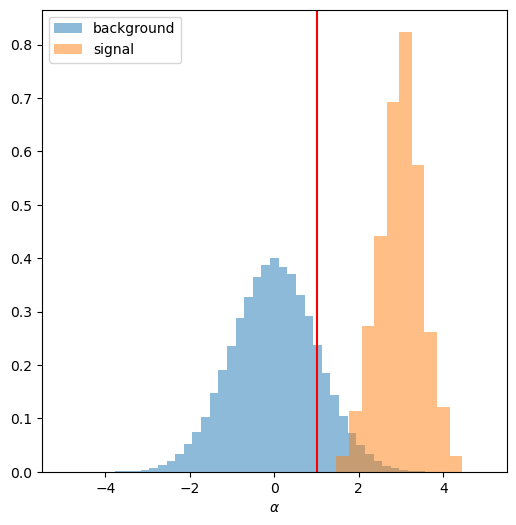

In [11]:
plt.figure(figsize=(6,6))
bins = np.linspace(-5, 5, 50)
# Background
plt.hist(x1, bins=bins, density=True, alpha = 0.5, label="background")
# Signal
plt.hist(x3, density=True, alpha = 0.5, label="signal")
plt.xlabel('$\\alpha$')
plt.axvline(x=1, color='r', linestyle='-')
plt.legend()
plt.show
plt.savefig('plots/full_bkg_sig_1D.pdf')
plt.close

In [12]:
k_list = [0, 0.2, 0.5, 0.8, 1, 1.5, 2]
theta_1D_list = [0]*len(k_list)
Y1D_list = []
for k in k_list:
    Y1D_list.append(Y(k, 0, x1, x1))

In [13]:
samples1D_CR_list, samples1D_SR_list = MAF1D(Y1D_list, x1)

  3%|          | 26/1000 [01:32<57:41,  3.55s/it]


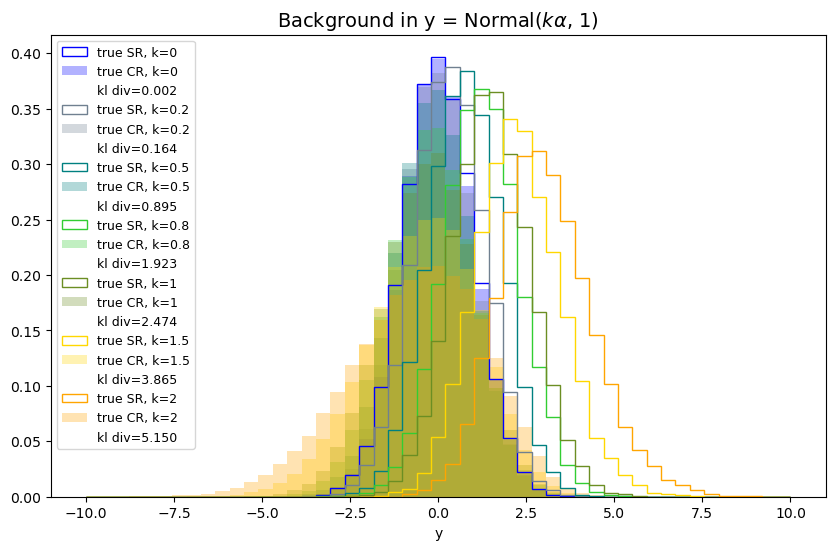

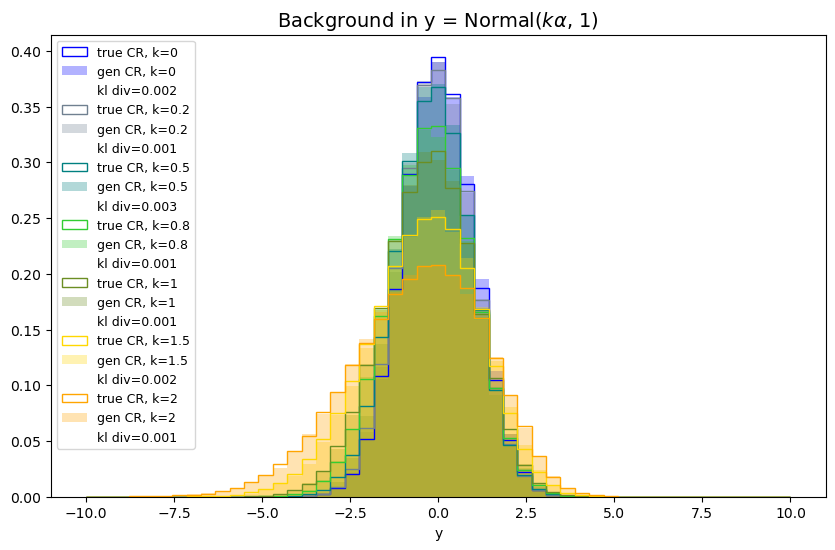

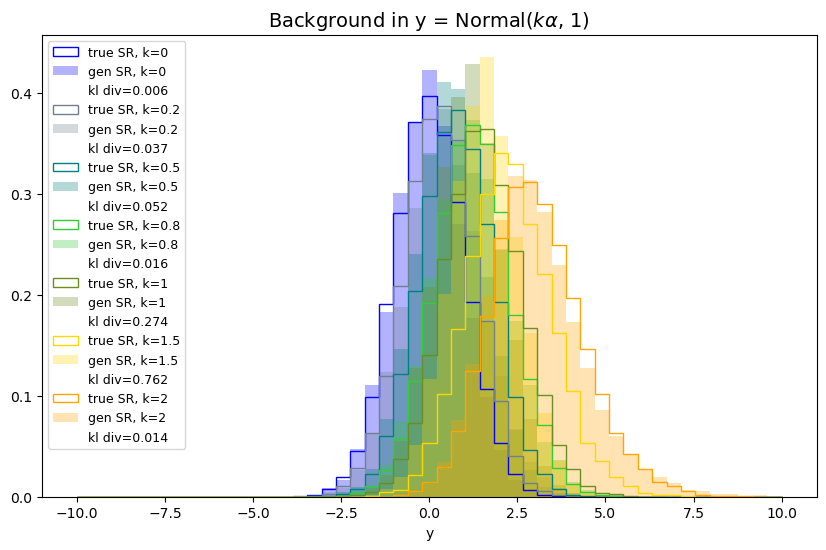

In [14]:
plot_kwargs = {"title":"Normal($k\\alpha$, 1)", "tag":"1DSR", "ymin":-10, "ymax":10}
plot_results(k_list, None, Y1D_list, samples1D_CR_list, samples1D_SR_list, mask_CR1D, mask_SR1D, plot_kwargs)

## Inference in 2D

<function matplotlib.pyplot.close(fig=None)>

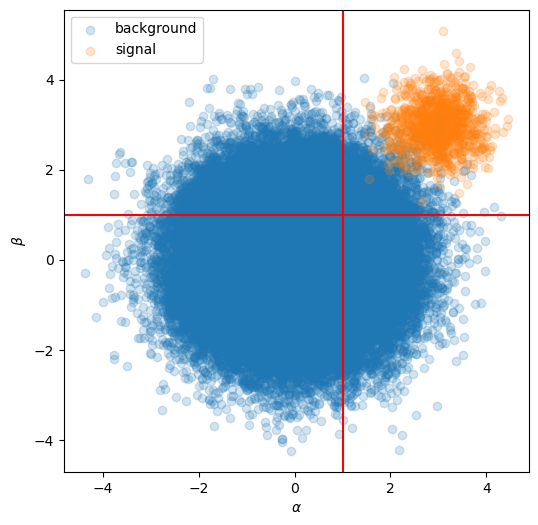

In [15]:
plt.figure(figsize=(6,6))
# Background
plt.scatter(x1, x2, alpha = 0.2, label="background")
# Signal
plt.scatter(x3, x4, alpha = 0.2, label="signal")
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=1, color='r', linestyle='-')
plt.legend()
plt.show
plt.savefig('plots/full_bkg_sig_2D.pdf')
plt.close

Blues shows the background events, and orange shows the signal events. The red lines define the CRs and SR. The upper right region is SR.

### Equalized 2D inference

In [16]:
k_list = [0, 0.2, 0.5, 0.8, 1, 1.5, 2]
theta_E2D_list = [pi/4]*len(k_list)
Y_E2D_list = []
for i in range(len(k_list)):
    Y_E2D_list.append(Y(k_list[i], theta_E2D_list[i], x1, x2))

In [17]:
samples_E2D_CR_list, samples_E2D_SR_list = MAF2D(Y_E2D_list, data)

  2%|          | 24/1000 [01:35<1:04:24,  3.96s/it]


In [22]:
samples_E2D_SR_list[0].shape

(2485,)

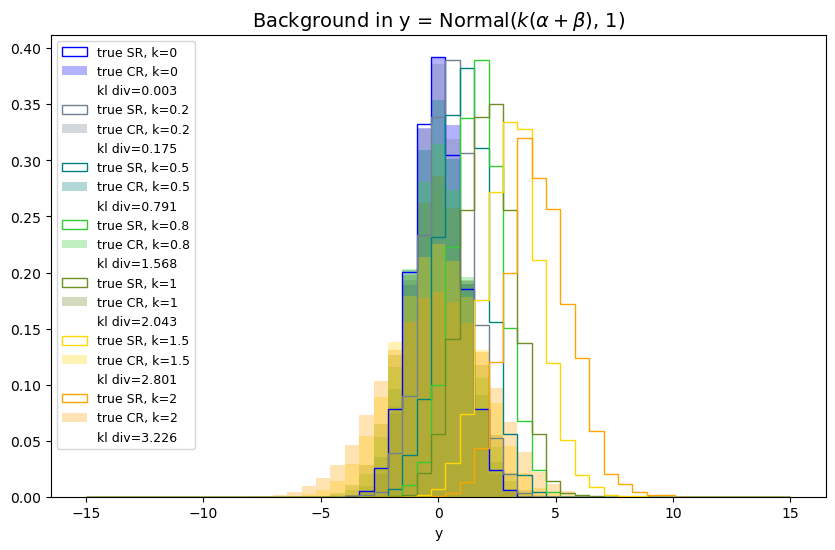

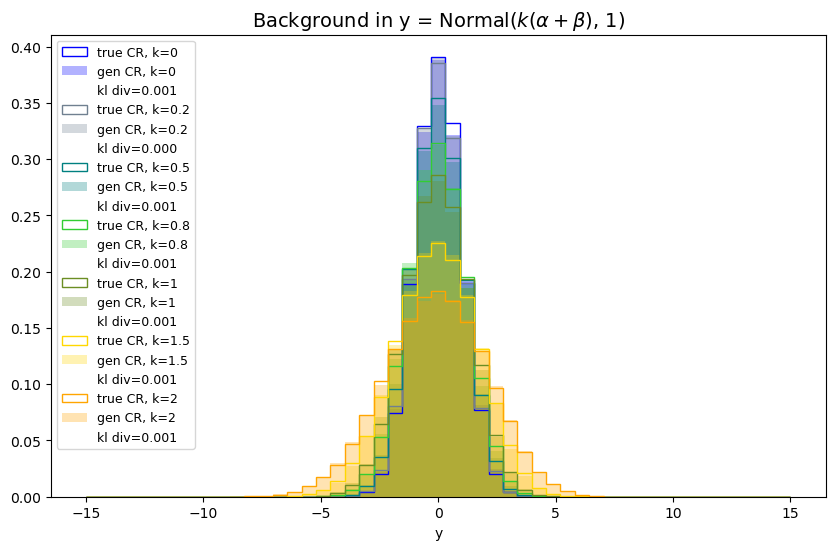

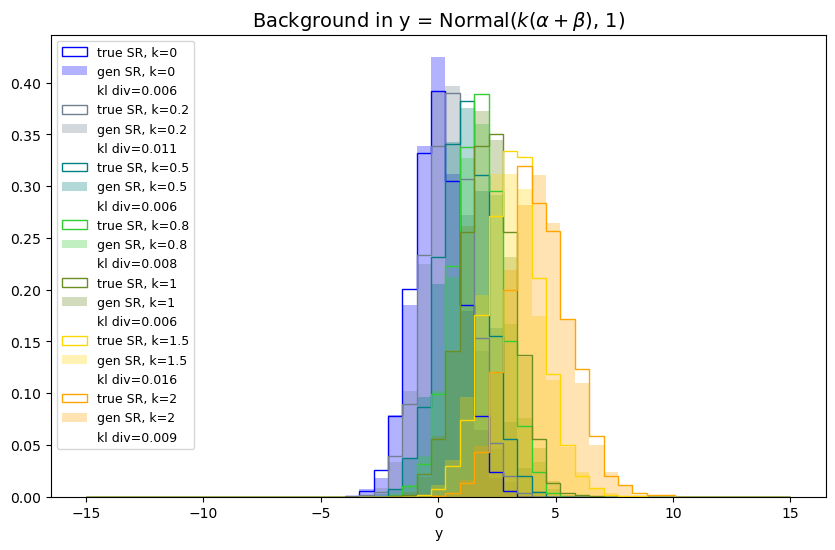

In [17]:
plot_kwargs = {"title":"Normal($k(\\alpha+\\beta)$, 1)", "tag":"E2DSR", "ymin":-15, "ymax":15}
plot_results(k_list, None, Y_E2D_list, samples_E2D_CR_list, samples_E2D_SR_list, mask_CR, mask_SR, plot_kwargs)

### General 2D inference

In [18]:
k_2D_list = [0.5, 0.5, 1, 1, 1.5, 1.5]
theta_2D_list = [pi/8, 3*pi/8, pi/8, 3*pi/8, pi/8, 3*pi/8]
Y_2D_list = []
for i in range(len(k_2D_list)):
    Y_2D_list.append(Y(k_2D_list[i], theta_2D_list[i], x1, x2))

In [19]:
samples_2D_CR_list, samples_2D_SR_list = MAF2D(Y_2D_list, data)

  4%|          | 44/1000 [03:28<1:15:29,  4.74s/it]


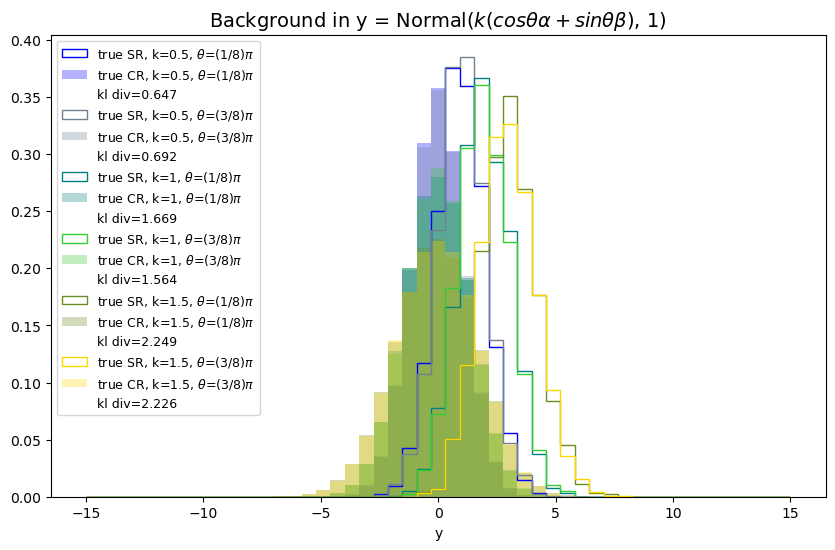

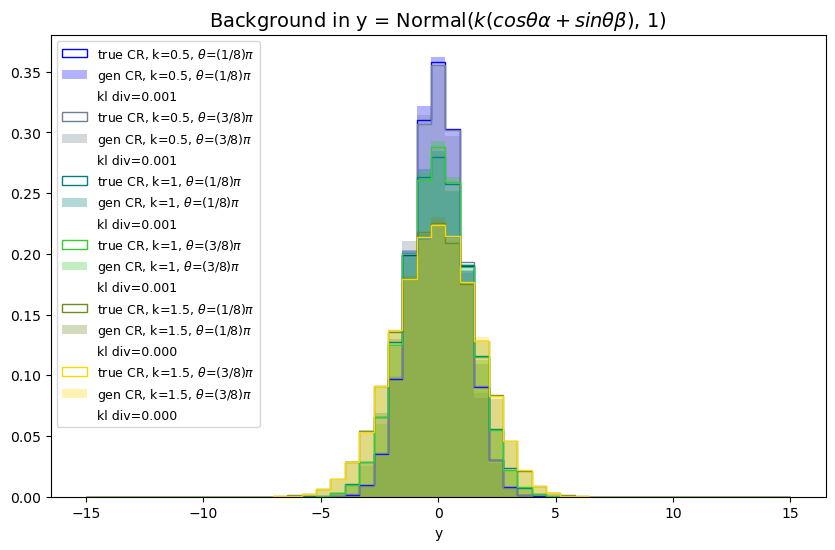

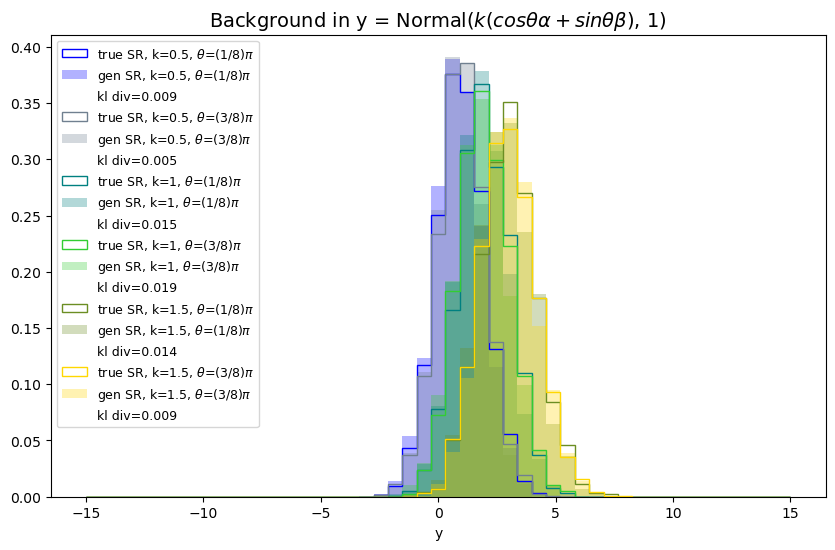

In [20]:
plot_kwargs = {"tag":"2DSR", "ymin":-15, "ymax":15}
plot_results(k_2D_list, theta_2D_list, Y_2D_list, samples_2D_CR_list, samples_2D_SR_list, mask_CR, mask_SR, plot_kwargs)

## Counter example: break CATHODE

**Inference variable**

$$
P(y) = N(k ( \cos{\theta} \alpha + \sin{\theta} \beta), 1) + k ( \cos{\theta} \alpha^2 + \sin{\theta} \beta^2)
$$


### 1D inference

$$
P(y) = N(k\alpha, 1) + k \alpha^2
$$


In [21]:
def Y2(k, theta, x1, x2, n=N1, sigma=1):
    return (np.random.normal(k*(cos(theta)*x1 + sin(theta)*x2), sigma, n) + k*(cos(theta)*x1*x1 + sin(theta)*x2*x2)).astype(dtype=np.float32)

In [22]:
k2_list = [0, 0.5, 1, 1.5, 2]
theta_1D_list = [0]*len(k_list)
Y2_1D_list = []
for k in k2_list:
    Y2_1D_list.append(Y2(k, 0, x1, x2))

In [23]:
samples1D_CR_list2, samples1D_SR_list2 = MAF1D(Y2_1D_list, x1)

  1%|          | 13/1000 [00:58<1:13:47,  4.49s/it]


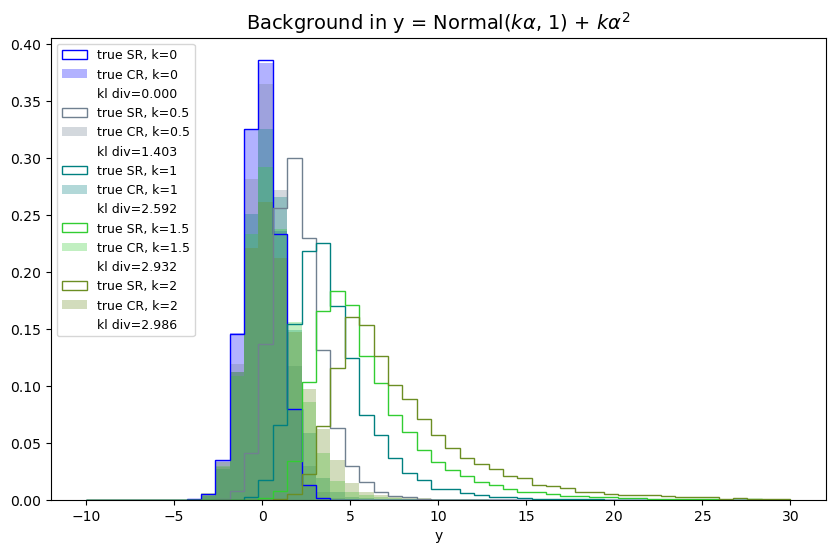

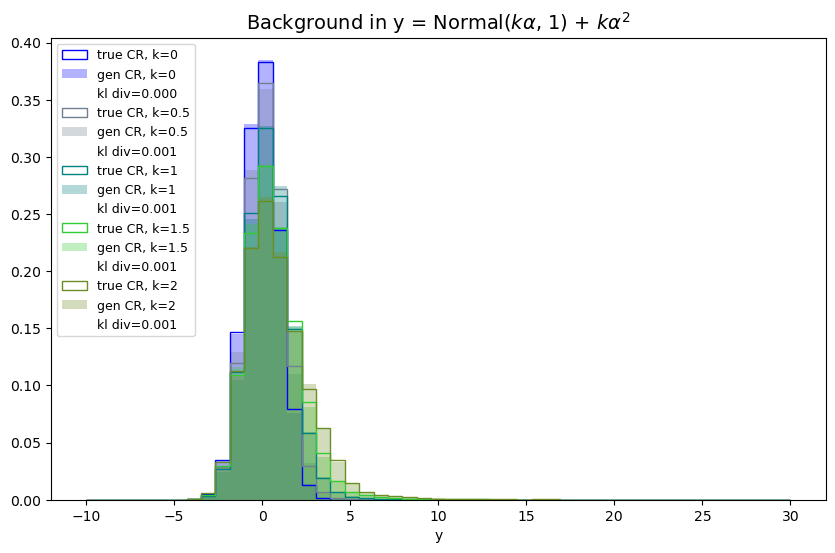

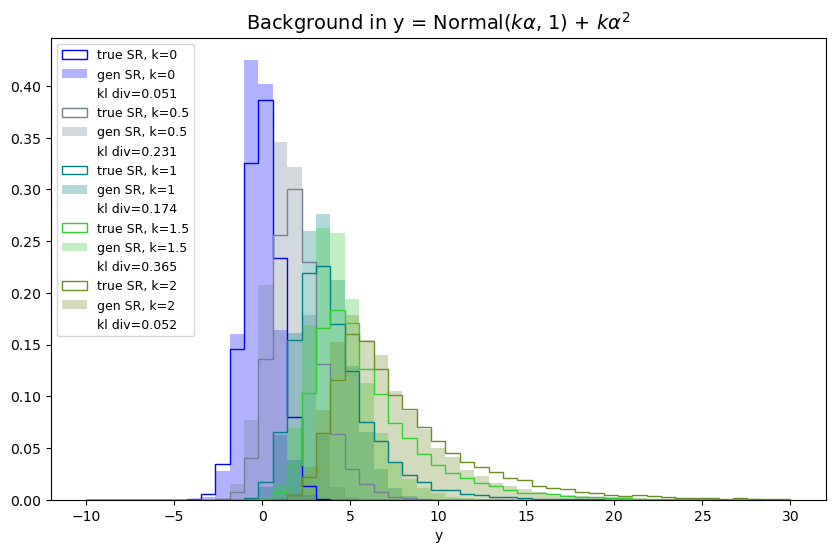

In [24]:
plot_kwargs = {"title":"Normal($k\\alpha$, 1) + $k\\alpha^2$", "tag":"1DSR_y2", "ymin":-10, "ymax":30}
plot_results(k2_list, None, Y2_1D_list, samples1D_CR_list2, samples1D_SR_list2, mask_CR1D, mask_SR1D, plot_kwargs)

### 2D inference

$$
P(y) = N(k (\alpha + \beta), 1) + k ( \alpha^2 + \beta^2)
$$

In [25]:
theta_E2D_list = [pi/4]*len(k_list)
Y2_E2D_list = []
for i in range(len(k2_list)):
    Y2_E2D_list.append(Y(k2_list[i], theta_E2D_list[i], x1, x2))

In [26]:
samples_E2D_CR_list2, samples_E2D_SR_list2 = MAF2D(Y2_E2D_list, data)

  8%|>         | 77/1000 [06:08<1:13:37,  4.79s/it]


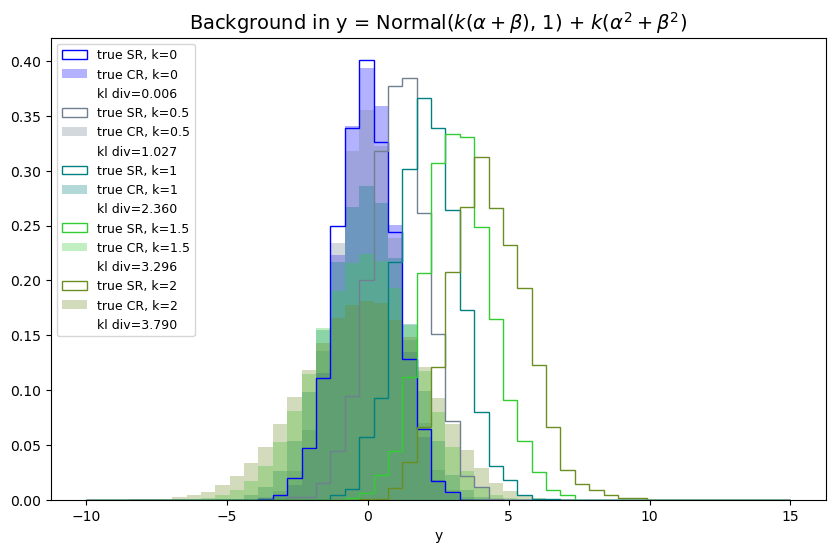

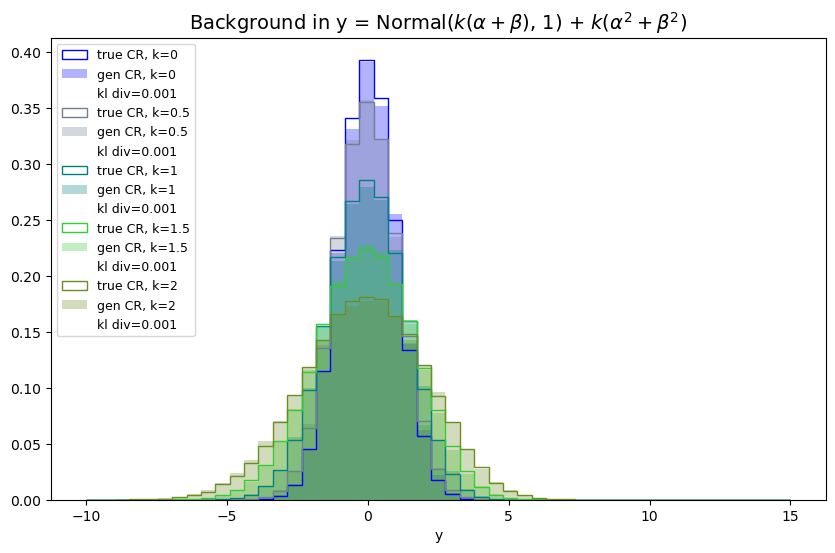

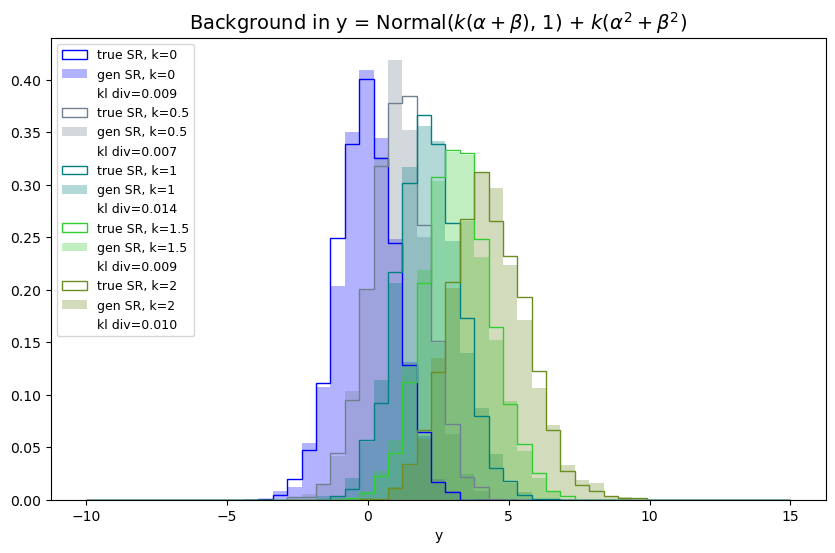

In [29]:
plot_kwargs = {"title":"Normal($k(\\alpha + \\beta)$, 1) + $k(\\alpha^2 + \\beta^2)$", "tag":"E2DSR_y2", "ymin":-10, "ymax":15}
plot_results(k2_list, None, Y2_E2D_list, samples_E2D_CR_list2, samples_E2D_SR_list2, mask_CR, mask_SR, plot_kwargs)